In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import optax
from IPython.display import clear_output

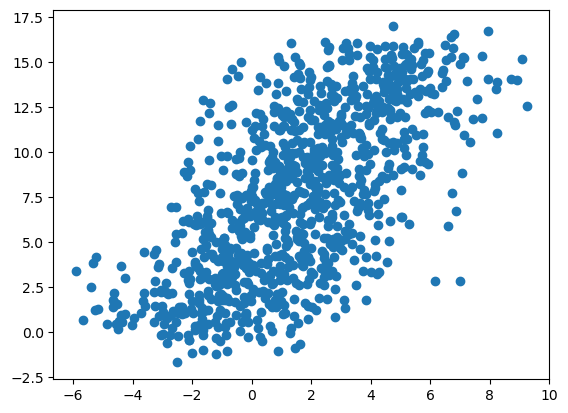

In [74]:
# Model True data
x_true = np.random.uniform(size=1_000, low=-2, high=+5)
a = 2.3
b = 4.2

y_true = x_true*a + b 

# Add noise
npoints = len(x_true)
sigmay, sigmax = 0.8, 2
y = y_true + np.random.normal(size=npoints, loc=0, scale=sigmay)
x = x_true + np.random.normal(size=npoints, loc=0, scale=sigmax)

# Jax
y = jnp.asarray(y)
x = jnp.asarray(x)



import pandas
data = pandas.DataFrame({"x":x, "y":y, "dx": sigmax, "dy": sigmay})

xdata = jnp.asarray(data["x"])
ydata = jnp.asarray(data["y"])
xerr = jnp.asarray(data["dx"])
yerr = jnp.asarray(data["dx"])


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(xdata, ydata)

In [85]:
@jax.jit
def model(x_, a_, b_):
    return a_*x_ + b_

@jax.jit
def chi2(param):
    alpha = param["alpha"]
    beta = param["beta"]
    xmodel = param.get("x", xdata)
    
    ymodel = model(xmodel, alpha, beta)
    chi2_perpoint_y = (ydata - ymodel)**2/yerr**2
    chi2_perpoint_x = (xdata - xmodel)**2/xerr**2
    
    return jnp.sum(chi2_perpoint_y + chi2_perpoint_x)

def optaxAdam(func, param, step, imax, args=()):
    
    solver = optax.adam(learning_rate=step)
    opt_state = solver.init(param)
    
    gradfunc = jax.grad(func)

    aguesses = []
    bguesses = []
    loss = []
    
    #print(f"Guess 0 : {param}")
    for i in range(imax):
        grad = gradfunc(param)
        updates, opt_state = solver.update(grad, opt_state, param)
        param = optax.apply_updates(param, updates)
        
        aguesses.append(param["alpha"])
        bguesses.append(param["beta"])
        loss.append(func(param))
        
    print(f"Final param : a: {param['alpha']:.2f} and b: {param['beta']:.2f}", )
    return aguesses, bguesses, loss, param



In [83]:
param.get("t", 3)

3

In [92]:
%%time 
guess = {"alpha": jnp.asarray(1., dtype="float32"),
         "beta": jnp.asarray(1., dtype="float32"),
        "x": xdata
        }
         
aguesses, bguesses, loss, param = optaxAdam(chi2, guess, 0.05, imax=800)

Final param : a: 2.19 and b: 4.28
CPU times: user 2.84 s, sys: 5.28 ms, total: 2.84 s
Wall time: 2.84 s


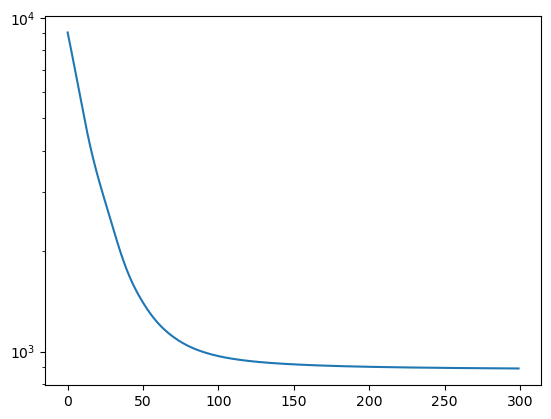

In [91]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(loss)
ax.set_yscale("log")

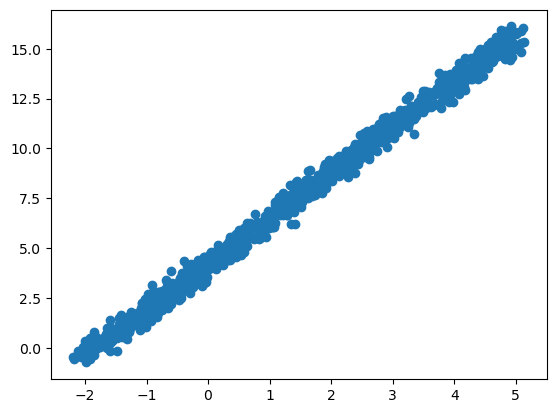

In [42]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(xdata, ydata)

In [ ]:
def displayPlot1():
    minAs = jnp.min(jnp.append(aguesses,a-1))
    maxAs = jnp.max(jnp.append(aguesses,a+1))
    minBs = jnp.min(jnp.append(bguesses,b-1))
    maxBs = jnp.max(jnp.append(bguesses,b+1))
    As = np.arange(minAs, maxAs, 0.01)
    Bs = np.arange(minBs, maxBs, 0.01)
    As, Bs = np.meshgrid(As, Bs)
    Ys = sumkhi2([As, Bs])
    
    angle = 0
    while True:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection="3d")   
        ax.set_title("Optimisation par descente de gradient")
        ax.set_xlabel("A")
        ax.set_ylabel("B")
        ax.set_zlabel("sumkhi2 des ...")
        surf = ax.plot_surface(As, Bs, Ys , cmap=matplotlib.cm.coolwarm, linewidth=0, alpha=0.75, antialiased=False)
        ax.scatter(aguesses, bguesses, sumkhi2([aguesses, bguesses]), marker="o", c="#FF00FE", alpha=1)
        ax.scatter(a, b, sumkhi2([a, b]), marker="x", s=70, c="red")
        ax.scatter(fguess[0], fguess[1], sumkhi2(fguess), marker="o", s=50, c="#00DE25")
        ax.legend(["points du plan", "paramètres trouvés au cours de l'optimisation", "vrais paramètres", "derniers paramètres trouvés"])
        ax.view_init(30, angle, 0)
        clear_output(wait=True)
        plt.pause(.001)
        angle = (angle + 1) % 360

def displayPlot2() :
    fig, ax = plt.subplots()
    plt.title("Valeur du loss dans une optimisation par descente de gradient")
    ax.set_xlabel("numéro du pas")
    ax.set_ylabel("sumkhi2 des paramètres trouvés à ce pas")
    steps = np.arange(0, jnp.size(aguesses), 1)
    ax.scatter(steps, sumkhi2([aguesses, bguesses]))

n = 999
a = 9
b = 4
s = 0.2
xs = jnp.array(np.random.uniform(size=n))
err = jnp.array(np.random.normal(0, scale=s, size=n))

#aguesses, bguesses, fguess = minimize(sumkhi2, [8.97, 0.], 0.001, 20)
aguesses, bguesses, fguess = optaxAdam(sumkhi2, [8.97, 0.], 0.1, 600)